# TITANIC ML DATASET(DM)

# With the following code, I was able to get an accuracy score of 0.81100 (about 800-1000 rank). 
The code is straightforward simple and easy to implement using ML Classifiers.
Various different classifiers were implemented, and RandomForestClassifier gave me the best score.

# Feel free to upvote if you found this helpful.

Thanks

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# Importing the Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Importing the datasets

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train_len = len(train)

# Let's first consider Training Data


Nan values in the Training Set

In [5]:
#percentage of nan values present in each feature
features_nan=[feature for feature in train.columns if train[feature].isnull().sum()>0]

for feature in features_nan:
    print(feature, np.round(train[feature].isnull().mean()*100, 2),  ' % missing values')

Age 19.87  % missing values
Cabin 77.1  % missing values
Embarked 0.22  % missing values


observe numeric and categorical values separately 

In [6]:
num = train[['Age','SibSp','Parch','Fare']]
cat = train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]
#num, #cat

# EXPLORING DATA USING VISUALIZATIONS

# Distributions of Variables in Training Datasets

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


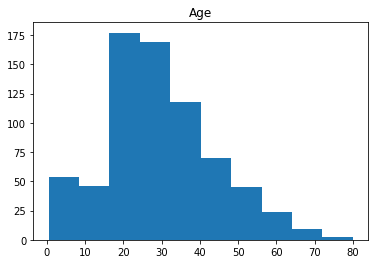

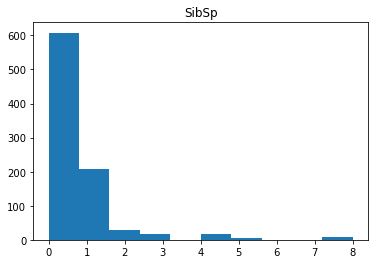

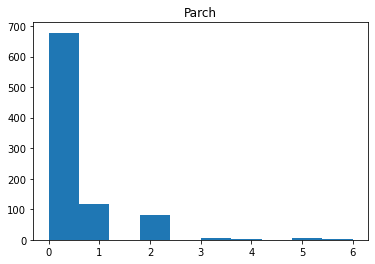

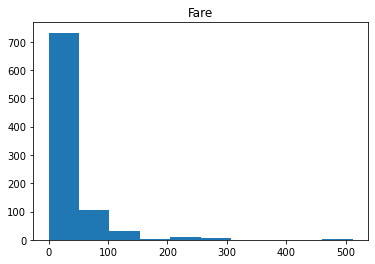

In [7]:
#distributions for all numeric variables 
for i in num.columns:
    plt.hist(num[i])
    plt.title(i)
    plt.show()

In [8]:
print(num.corr())

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


In [9]:
#compare survival rate across Age, SibSp, Parch, and Fare 
#pd.pivot_table(train, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

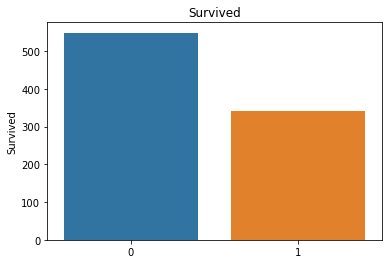

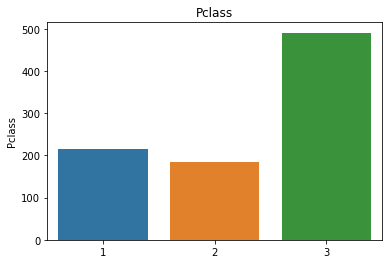

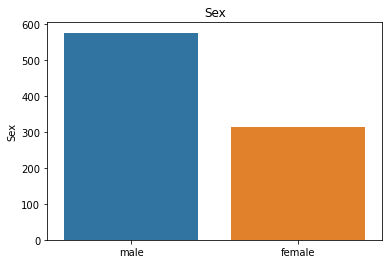

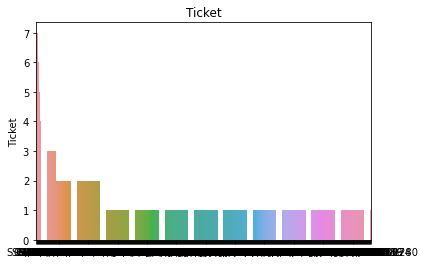

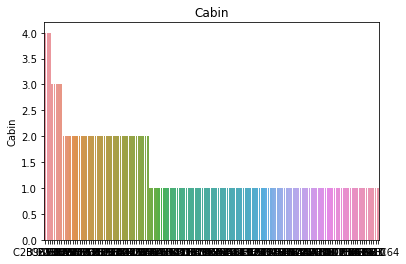

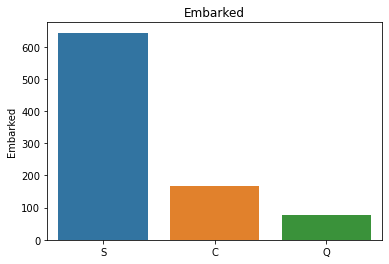

In [10]:
for i in cat.columns:
    sns.barplot(cat[i].value_counts().index,cat[i].value_counts()).set_title(i)
    plt.show()

# Comparing survival for low cardinality categorical variables 

In [11]:
print(pd.pivot_table(train, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


# Taking care of Cabin Variable 

Creating a Deck variable from Cabin Variable

In [12]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
train['Deck'] = train['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
train.Deck.unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [13]:
train_deck = train.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 
                                                                        'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()
train_deck

Deck     A   B   C   D      E        F     G   M            T
Pclass   1   1   1   1  2   1  2  3  2  3  3   1    2    3  1
Count   15  47  59  29  4  25  4  3  8  5  4  40  168  479  1

In [14]:
# Passenger in the T deck is changed to A
idx = train[train['Deck'] == 'T'].index
train.loc[idx, 'Deck'] = 'A'

In [15]:
train_survived = train.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass',
                                                                                   'Cabin', 'PassengerId', 
                                                                                   'Ticket']).rename(columns={'Name':'Count'}).transpose()
train_survived

Deck      A      B       C      D      E      F     G       M     
Survived  0  1   0   1   0   1  0   1  0   1  0  1  0  1    0    1
Count     9  7  12  35  24  35  8  25  8  24  5  8  2  2  481  206

In [16]:
pd.pivot_table(train,index='Survived',columns='Deck', values = 'Name', aggfunc='count')

Deck,A,B,C,D,E,F,G,M
Survived,,,,,,,,
0,9,12,24,8,8,5,2,481
1,7,35,35,25,24,8,2,206


In [17]:
deck_mapping = {"A": 1, "B": 2, "C": 3, "D": 4,"E": 5,"F": 6,"G": 7,"M": 8 }
train['Deck'] = train['Deck'].map(deck_mapping)

In [18]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,8


# Let's consider Test Data

In [19]:
#percentage of nan values present in each feature
features_nan=[feature for feature in test.columns if train[feature].isnull().sum()>0]

for feature in features_nan:
    print(feature, np.round(test[feature].isnull().mean()*100, 2),  ' % missing values')

Age 20.57  % missing values
Cabin 78.23  % missing values
Embarked 0.0  % missing values


In [20]:
test['Deck'] = test['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
test.Deck.unique()

array(['M', 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

In [21]:
test_deck = test.groupby(['Deck', 'Pclass']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 
                                                                        'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()
test_deck

Deck    A   B   C   D     E  F     G   M         
Pclass  1   1   1   1  2  1  2  3  3   1   2    3
Count   7  18  35  11  2  9  5  3  1  27  86  214

In [22]:
deck_mapping = {"A": 1, "B": 2, "C": 3, "D": 4,"E": 5,"F": 6,"G": 7,"M": 8 }
test['Deck'] = test['Deck'].map(deck_mapping)

In [23]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,8
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,8
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,8
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,8
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,8


# Feature Engineering and taking care of missing values

In [24]:
dataset = pd.concat([train, test], sort=True).reset_index(drop=True)
dataset.head()

,Age,Cabin,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,8,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,3,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,8,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,3,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,8,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


Understanding Ticket Variable

In [25]:
dataset['num_Ticket'] = dataset.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
dataset['num_Ticket'].value_counts()

1    957
0    352
Name: num_Ticket, dtype: int64

In [26]:
dataset['Ticket_letters'] = dataset.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').
                                             replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
pd.set_option("max_rows", None)
dataset['Ticket_letters'].value_counts()

0            961
pc            92
ca            68
a5            28
sotonoq       24
stono2        21
scparis       19
wc            15
a4            10
fcc            9
soc            8
c              8
sopp           7
wep            4
scah           4
pp             4
sotono2        3
fc             3
swpp           2
sc             2
ppp            2
sca4           2
sop            1
as             1
sp             1
scahbasle      1
sca3           1
aq4            1
scow           1
aq3            1
casoton        1
stonoq         1
lp             1
fa             1
a2             1
Name: Ticket_letters, dtype: int64

In [27]:
dataset.head()

,Age,Cabin,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,num_Ticket,Ticket_letters
0,22.0,NaN,8,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,a5
1,38.0,C85,3,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,pc
2,26.0,NaN,8,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,stono2
3,35.0,C123,3,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,1,0
4,35.0,NaN,8,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,0


Since ,Cabin and Ticket have been used for creating new variables 'Deck', ['num_Ticket', & 'Ticket_letters']

# Now, we take care of the missing values

First, create Title and Surname(Last Name) from Name

In [28]:
#extract Title from Name 
dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.', expand=False)
pd.crosstab(dataset['Title'], dataset['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [29]:
title_mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs' }
dataset.replace({'Title': title_mapping}, inplace=True)
#titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
#dataset['Title'] = dataset['Title'].map(title_mapping)

In [30]:
#encode title variables
title_num_mapping = {"Dr": 1, "Master": 2, "Miss": 3, "Mr": 4,"Mrs": 5,"Rev": 6}
dataset['Title'] = dataset['Title'].map(title_num_mapping)

In [31]:
dataset.Title.unique()

array([4, 5, 3, 2, 6, 1])

In [32]:
#dataset['Title'] = dataset['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'Countess', 'Dona'], 'Miss/Mrs/Ms')
#dataset['Title'] = dataset['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

In [33]:
# Extracting surnames from Name
dataset['Last_Name'] = dataset['Name'].apply(lambda x: str.split(x, ",")[0])

In [34]:
dataset.Last_Name.unique()

array(['Braund', 'Cumings', 'Heikkinen', 'Futrelle', 'Allen', 'Moran',
       'McCarthy', 'Palsson', 'Johnson', 'Nasser', 'Sandstrom', 'Bonnell',
       'Saundercock', 'Andersson', 'Vestrom', 'Hewlett', 'Rice',
       'Williams', 'Vander Planke', 'Masselmani', 'Fynney', 'Beesley',
       'McGowan', 'Sloper', 'Asplund', 'Emir', 'Fortune', "O'Dwyer",
       'Todoroff', 'Uruchurtu', 'Spencer', 'Glynn', 'Wheadon', 'Meyer',
       'Holverson', 'Mamee', 'Cann', 'Nicola-Yarred', 'Ahlin', 'Turpin',
       'Kraeff', 'Laroche', 'Devaney', 'Rogers', 'Lennon', "O'Driscoll",
       'Samaan', 'Arnold-Franchi', 'Panula', 'Nosworthy', 'Harper',
       'Faunthorpe', 'Ostby', 'Woolner', 'Rugg', 'Novel', 'West',
       'Goodwin', 'Sirayanian', 'Icard', 'Harris', 'Skoog', 'Stewart',
       'Moubarek', 'Nye', 'Crease', 'Kink', 'Jenkin', 'Hood',
       'Chronopoulos', 'Bing', 'Moen', 'Staneff', 'Moutal', 'Caldwell',
       'Dowdell', 'Waelens', 'Sheerlinck', 'McDermott', 'Carrau', 'Ilett',
       'Backstrom

# Encode categorical variables

In [35]:
#encode Embarked 
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [36]:
#encode Sex 
sex_mapping = {"female": 1, "male": 2}
dataset['Sex'] = dataset['Sex'].map(sex_mapping)

In [37]:
dataset.head()

,Age,Cabin,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,num_Ticket,Ticket_letters,Title,Last_Name
0,22.0,NaN,8,1.0,7.2500,"Braund, Mr. Owen Harris",0,1,3,2,1,0.0,A/5 21171,0,a5,4,Braund
1,38.0,C85,3,2.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599,0,pc,5,Cumings
2,26.0,NaN,8,1.0,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282,0,stono2,3,Heikkinen
3,35.0,C123,3,1.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803,1,0,5,Futrelle
4,35.0,NaN,8,1.0,8.0500,"Allen, Mr. William Henry",0,5,3,2,0,0.0,373450,1,0,4,Allen


Now, take care of some missing values

In [38]:
dataset[dataset['Age'].isnull()]
#null_data = df[df.isnull().any(axis=1)]
#df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,num_Ticket,Ticket_letters,Title,Last_Name
5,NaN,NaN,8,3.0,8.4583,"Moran, Mr. James",0,6,3,2,0,0.0,330877,1,0,4,Moran
17,NaN,NaN,8,1.0,13.0000,"Williams, Mr. Charles Eugene",0,18,2,2,0,1.0,244373,1,0,4,Williams
19,NaN,NaN,8,2.0,7.2250,"Masselmani, Mrs. Fatima",0,20,3,1,0,1.0,2649,1,0,5,Masselmani
26,NaN,NaN,8,2.0,7.2250,"Emir, Mr. Farred Chehab",0,27,3,2,0,0.0,2631,1,0,4,Emir
28,NaN,NaN,8,3.0,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,29,3,1,0,1.0,330959,1,0,3,O'Dwyer
29,NaN,NaN,8,1.0,7.8958,"Todoroff, Mr. Lalio",0,30,3,2,0,0.0,349216,1,0,4,Todoroff
31,NaN,B78,2,2.0,146.5208,"Spencer, Mrs. William Augustus (Marie Eugenie)",0,32,1,1,1,1.0,PC 17569,0,pc,5,Spencer
32,NaN,NaN,8,3.0,7.7500,"Glynn, Miss. Mary Agatha",0,33,3,1,0,1.0,335677,1,0,3,Glynn
36,NaN,NaN,8,2.0,7.2292,"Mamee, Mr. Hanna",0,37,3,2,0,1.0,2677,1,0,4,Mamee
42,NaN,NaN,8,2.0,7.8958,"Kraeff, Mr. Theodor",0,43,3,2,0,0.0,349253,1,0,4,Kraeff


In [39]:
dataset['Age'].isnull().sum()

263

In [40]:
age_corr=dataset.corr().abs().unstack().sort_values(ascending=False).reset_index()
#dataframe index is : [1,5,6,10,11] and I would like to reset it to [0,1,2,3,4] using reset_index()
#Reshaping the data using stack(), the column is stacked row wise
#default sorting algorithm is 'quicksort'
age_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
age_corr[age_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
11,Age,Age,1.000000
21,Age,Title,0.450598
22,Age,Pclass,0.408106
29,Age,Deck,0.315751
35,Age,SibSp,0.243699
44,Age,Fare,0.178740
50,Age,Parch,0.150917
80,Age,Survived,0.077221
88,Age,Sex,0.063645
99,Age,Embarked,0.048993


Age is highly correlated with Pclass, Title, Deck, SibSp

In [41]:
age_by_pclass_sex = dataset.groupby(['Sex', 'Pclass','Title','Deck','SibSp','Parch']).median()['Age']
age_by_pclass_sex

Sex  Pclass  Title  Deck  SibSp  Parch
1    1       1      4     0      0        49.00
             3      1     0      0        34.50
                    2     0      0        29.50
                                 1        16.00
                                 2        29.00
                          1      2        14.00
                          2      2        19.50
                    3     0      0        35.00
                                 2        31.00
                          1      0        33.00
                                 2         2.00
                          3      2        24.00
                    4     0      0        26.50
                                 1        16.00
                                 2        19.00
                          1      0        42.50
                    5     0      0        31.00
                                 1        22.00
                                 2        18.00
                          1      1        39.00
 

In [42]:
#taking care of missing values in Age
dataset['Age'] = dataset.groupby(['Pclass','SibSp'])['Age'].apply(lambda x: x.fillna(x.median()))

In [43]:
dataset.Age.isnull().sum()

0

In [44]:
#create an Ageband 
dataset['Ageband'] = pd.qcut(dataset['Age'], 10)
pd.pivot_table(dataset,index='Survived',columns='Ageband', values = 'Name', aggfunc='count')

Ageband,"(0.169, 16.0]","(16.0, 20.0]","(20.0, 24.0]","(24.0, 25.0]","(25.0, 26.0]","(26.0, 29.0]","(29.0, 34.0]","(34.0, 39.0]","(39.0, 48.0]","(48.0, 80.0]"
Survived,,,,,,,,,,
0.0,56,53,73,97,12,46,54,56,53,49
1.0,55,29,45,29,6,30,40,47,30,31


In [45]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
dataset['Ageband'] = encoder.fit_transform(dataset['Ageband'])
#dataset['AgeBin'] = pd.qcut(dataset['Age'], 4).astype(int)

#label = LabelEncoder()
#dataset['AgeBand'] = encoder.fit_transform(dataset['AgeBin'])

#dataset.drop(['Age'], 1, inplace=True)

In [46]:
#taking care of missing values in Embarked
dataset['Embarked'] = dataset['Embarked'].fillna('1')#S:1

In [47]:
fare_corr=dataset.corr().abs().unstack().sort_values(ascending=False).reset_index()
#dataframe index is : [1,5,6,10,11] and I would like to reset it to [0,1,2,3,4] using reset_index()
#Reshaping the data using stack(), the column is stacked row wise
#default sorting algorithm is 'quicksort'
fare_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
fare_corr[fare_corr['Feature 1'] == 'Fare']

,Feature 1,Feature 2,Correlation Coefficient
3,Fare,Fare,1.000000
16,Fare,Pclass,0.558629
19,Fare,Deck,0.548500
40,Fare,Survived,0.257307
46,Fare,Parch,0.221539
53,Fare,Age,0.195021
55,Fare,Ageband,0.192753
57,Fare,Sex,0.185523
58,Fare,num_Ticket,0.174713
61,Fare,SibSp,0.160238


In [48]:
dataset[dataset['Fare'].isnull()]

,Age,Cabin,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,num_Ticket,Ticket_letters,Title,Last_Name,Ageband
1043,60.5,NaN,8,1,NaN,"Storey, Mr. Thomas",0,1044,3,2,0,NaN,3701,1,0,4,Storey,9


In [49]:
med_fare=dataset.groupby(['SibSp', 'Parch', 'Pclass','Sex'])['Fare'].median()[0][0][3][2]
med_fare
dataset['Fare']=dataset['Fare'].fillna(med_fare)

In [50]:
med_fare

7.8875

In [51]:
dataset.isnull().sum()

Age                  0
Cabin             1014
Deck                 0
Embarked             0
Fare                 0
Name                 0
Parch                0
PassengerId          0
Pclass               0
Sex                  0
SibSp                0
Survived           418
Ticket               0
num_Ticket           0
Ticket_letters       0
Title                0
Last_Name            0
Ageband              0
dtype: int64

Now, the missing values have been taken care of

# Create a new variable Family Survival

In [52]:
#create Family_Size and IsAlone
dataset['Family_Size'] = dataset['SibSp'] + dataset['Parch'] + 1
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
dataset['Family_Size_Band'] = dataset['Family_Size'].map(family_map)
dataset['IsAlone'] = dataset['Family_Size'].map(lambda s: 1
                                                   if s == 1 else 0)

This was taken from another kernel and increased the accuracy(by) manifold!!!

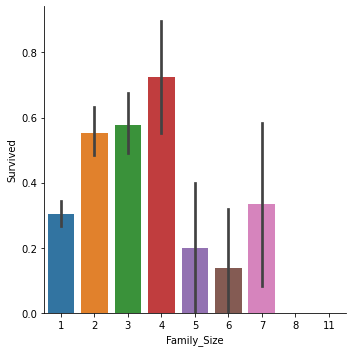

In [53]:
DEFAULT_SURVIVAL_VALUE = 0.5
dataset['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in dataset[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 0
                
for _, grp_df in dataset.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    dataset.loc[dataset['PassengerId'] == passID, 'Family_Survival'] = 0
                        

sns.catplot(x="Family_Size",y="Survived",data = dataset.iloc[:train_len],kind="bar")

On combined dataset, we will perform Feature Engineering

In [54]:
#create a Fareband
dataset['Fareband'] = pd.qcut(dataset['Fare'], 13)
pd.pivot_table(dataset,index='Survived',columns='Fareband', values = 'Name', aggfunc='count')

Fareband,"(-0.001, 7.25]","(7.25, 7.75]","(7.75, 7.896]","(7.896, 8.05]","(8.05, 10.5]","(10.5, 13.0]","(13.0, 15.742]","(15.742, 23.25]","(23.25, 26.55]","(26.55, 34.075]","(34.075, 56.496]","(56.496, 83.475]","(83.475, 512.329]"
Survived,,,,,,,,,,,,,
0.0,72,39,68,48,60,35,33,32,41,40,41,25,15
1.0,11,18,15,14,18,30,16,36,36,25,34,38,51


In [55]:
dataset.head()

,Age,Cabin,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,...,num_Ticket,Ticket_letters,Title,Last_Name,Ageband,Family_Size,Family_Size_Band,IsAlone,Family_Survival,Fareband
0,22.0,NaN,8,1,7.2500,"Braund, Mr. Owen Harris",0,1,3,2,...,0,a5,4,Braund,2,2,Small,0,0.5,"(-0.001, 7.25]"
1,38.0,C85,3,2,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,...,0,pc,5,Cumings,7,2,Small,0,0.5,"(56.496, 83.475]"
2,26.0,NaN,8,1,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,...,0,stono2,3,Heikkinen,4,1,Alone,1,0.5,"(7.896, 8.05]"
3,35.0,C123,3,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,...,1,0,5,Futrelle,7,2,Small,0,0.0,"(34.075, 56.496]"
4,35.0,NaN,8,1,8.0500,"Allen, Mr. William Henry",0,5,3,2,...,1,0,4,Allen,7,1,Alone,1,0.5,"(7.896, 8.05]"


In [56]:
#title_mapping = {"Mr": 0, "Miss/Mrs/Ms": 1, "Master": 2, "Dr/Military/Noble/Clergy": 3}
#dataset['Title'] = dataset['Title'].map(title_mapping)

In [57]:
#sex_mapping = {"female": 0, "male": 1}
#dataset['Sex'] = dataset['Sex'].map(sex_mapping)

In [58]:
#embarked_mapping = {"S": 0, "C": 1, "Q": 2}
#dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

# Encodings

Label Encodings

In [59]:
dataset.Fareband=encoder.fit_transform(dataset.Fareband)
dataset.Family_Size_Band=encoder.fit_transform(dataset.Family_Size_Band)

In [60]:
#remove unwanted columns part 1
dataset.drop(labels=['Cabin', 'Fare', 'Age', 'Name', 'PassengerId', 'Ticket', ], axis=1, inplace=True)

In [61]:
dataset.drop(labels=['Parch','SibSp','Survived','Last_Name'], axis=1, inplace=True)

In [62]:
dataset.drop(labels=['Ticket_letters'], axis=1, inplace=True)

In [63]:
dataset.head()

,Deck,Embarked,Pclass,Sex,num_Ticket,Title,Ageband,Family_Size,Family_Size_Band,IsAlone,Family_Survival,Fareband
0,8,1,3,2,0,4,2,2,3,0,0.5,0
1,3,2,1,1,0,5,7,2,3,0,0.5,11
2,8,1,3,1,0,3,4,1,0,1,0.5,3
3,3,1,1,1,1,5,7,2,3,0,0.0,10
4,8,1,3,2,1,4,7,1,0,1,0.5,3


In [64]:
dataset.shape

(1309, 12)

One Hot Encode other variables

In [65]:
#created dummy variables from categories (also can use OneHotEncoder)
#dummies = pd.get_dummies(dataset[['Deck','Pclass','Sex','Fareband',
                                  #'Embarked','Ageband', 'Family_Size','Family_Size_Band','num_Ticket','Title',
                                 #'IsAlone','Family_Survival']])

In [66]:
#dummies.shape

In [67]:
#dummies.head()

In [68]:
train_df = dataset.loc[:890]
test_df = dataset.loc[891:]

In [69]:
train_df.columns

Index(['Deck', 'Embarked', 'Pclass', 'Sex', 'num_Ticket', 'Title', 'Ageband',
       'Family_Size', 'Family_Size_Band', 'IsAlone', 'Family_Survival',
       'Fareband'],
      dtype='object')

In [70]:
test_df.shape

(418, 12)

Scaling the Dataset

In [71]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train=scaler.fit_transform(train_df)

In [72]:
X_test=scaler.fit_transform(test_df)

In [73]:
y_train=train.Survived
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# Model Building

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [75]:
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train,y_train,cv=5)
print(cv)
print(cv.mean()*100)

[0.7150838  0.74719101 0.79213483 0.80337079 0.81460674]
77.44774339338397


In [76]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train,y_train,cv=5)
print(cv)
print(cv.mean()*100)

[0.82122905 0.82022472 0.83707865 0.80898876 0.84269663]
82.60435628648548


In [77]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train,y_train,cv=5)
print(cv)
print(cv.mean()*100)

[0.79888268 0.78089888 0.83146067 0.76404494 0.83707865]
80.24731655263324


In [78]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train,y_train,cv=5)
print(cv)
print(cv.mean()*100)

[0.81564246 0.78651685 0.85393258 0.79213483 0.84269663]
81.81846713953928


In [79]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean()*100)

[0.82122905 0.78089888 0.84831461 0.78089888 0.86516854]
81.93019898311468


In [80]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train,y_train,cv=5)
print(cv)
print(cv.mean()*100)

[0.84916201 0.83707865 0.85955056 0.80898876 0.85955056]
84.28661100998053


In [81]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train,y_train,cv=5)
print(cv)
print(cv.mean()*100)

[0.82122905 0.78651685 0.86516854 0.79213483 0.85955056]
82.49199673592366


Voting Classifier 

In [82]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),
                                            ('rf',rf),('gnb',gnb),('svc',svc),
                                            ('xgb',xgb),('dt',dt)], voting = 'soft') 
cv = cross_val_score(voting_clf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.83240223 0.83146067 0.85955056 0.79775281 0.87640449]
0.8395141547925429


In [83]:
voting_clf.fit(X_train,y_train)
y_hat_base_vc = voting_clf.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
basic_submission_vc = {'PassengerId': testing.PassengerId, 'Survived': y_hat_base_vc}
base_submission_vc = pd.DataFrame(data=basic_submission_vc)
base_submission_vc.to_csv('base_submission_votingclf.csv', index=False)

# base_submission_votingclf.csv scored '0.77990'

# Model Tuned Performance

In [84]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [85]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

# 1. Logistic Regression

In [86]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve, cross_val_score
kfold = StratifiedKFold(n_splits=8)

In [87]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = kfold, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 8 folds for each of 40 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.6s


Logistic Regression
Best Score: 0.8328004343629344
Best Parameters: {'C': 0.23357214690901212, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    3.3s finished


In [88]:
'''Logistic Regression
Best Score: 0.8328004343629344
Best Parameters: {'C': 0.23357214690901212, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}'''

"Logistic Regression\nBest Score: 0.8328004343629344\nBest Parameters: {'C': 0.23357214690901212, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}"

# 2. KNN

In [89]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train,y_train)
clf_performance(best_clf_knn,'KNN')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8350072186303434
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.1s finished


In [90]:
'''KNN
Best Score: 0.8350072186303434
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}'''
#here, we got better score for cv=5 than cv=kfold!!!

"KNN\nBest Score: 0.8350072186303434\nBest Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}"

In [91]:
y_hat_knn = clf_knn.best_estimator_.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
basic_submission_knn = {'PassengerId': testing.PassengerId, 'Survived': y_hat_knn}
submission_knn = pd.DataFrame(data=basic_submission_knn)
submission_knn.to_csv('submission_clf_knn.csv', index=False)

# This got me a score of 0.78468

# 3. SVC

In [92]:
'''svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train,y_train)
clf_performance(best_clf_svc,'SVC')

y_hat_svc = clf_svc.best_estimator_.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
svc_submission = {'PassengerId': testing.PassengerId, 'Survived': y_hat_svc}
submission_svc = pd.DataFrame(data=svc_submission)
submission_svc.to_csv('submission_clf_svc.csv', index=False)'''

'''SVC
Best Score: 0.8428410018203504
Best Parameters: {'C': 10, 'degree': 2, 'kernel': 'poly'}'''

"SVC\nBest Score: 0.8428410018203504\nBest Parameters: {'C': 10, 'degree': 2, 'kernel': 'poly'}"

In [93]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['poly'], 'degree' : [2], 'C': [10]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


SVC
Best Score: 0.8428410018203504
Best Parameters: {'C': 10, 'degree': 2, 'kernel': 'poly'}


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [94]:
y_hat_svc = clf_svc.best_estimator_.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
svc_submission = {'PassengerId': testing.PassengerId, 'Survived': y_hat_svc}
submission_svc = pd.DataFrame(data=svc_submission)
submission_svc.to_csv('submission_clf_svc.csv', index=False)

# This got me a score of 0.79665 

# 4. Random Forest

with randomized search cv to get a guess

In [95]:
'''rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,4,5,6,7,8,9,10,15,20,50,None],
                                  'max_features': [3,'auto','sqrt','log2'],
                                  'bootstrap': [False, True],
                                  'criterion': ['gini', 'entropy'],
                                  'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10],
                                  'min_samples_split': [2 ,3,4,5,6,7,8,9,10]}
                                  
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 200, 
cv = 5, verbose = True, n_jobs = -1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train,y_train)
clf_performance(best_clf_rf_rnd,'Random Forest')'''

'''y_hat_rf_rnd = clf_rf_rnd.best_estimator_.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
rf_submission = {'PassengerId': testing.PassengerId, 'Survived': y_hat_rf_rnd}
submission_rf = pd.DataFrame(data=rf_submission)
submission_rf.to_csv('submission_clf_rf_rnd.csv', index=False)'''

'''Random Forest
Best Score: 0.8495762977841943
Best Parameters: {'n_estimators': 100, 'min_samples_split': 3, 
'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini', 'bootstrap': True}'''

"Random Forest\nBest Score: 0.8495762977841943\nBest Parameters: {'n_estimators': 100, 'min_samples_split': 3, \n'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini', 'bootstrap': True}"

In [96]:
'''#with stratified kfold
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,4,5,6,7,8,9,10,15,20,50,None],
                                  'max_features': [3,'auto','sqrt','log2'],
                                  'bootstrap': [False, True],
                                  'criterion': ['gini', 'entropy'],
                                  'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10],
                                  'min_samples_split': [2 ,3,4,5,6,7,8,9,10]}
                                  
clf_rf_rnd_2 = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 200, cv = kfold,
verbose = True, n_jobs = -1)
best_clf_rf_rnd_2 = clf_rf_rnd_2.fit(X_train,y_train)
clf_performance(best_clf_rf_rnd_2,'Random Forest')'''

'''y_hat_rf_rnd_2 = clf_rf_rnd_2.best_estimator_.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
rf_submission = {'PassengerId': testing.PassengerId, 'Survived': y_hat_rf_rnd_2}
submission_rf = pd.DataFrame(data=rf_submission)
submission_rf.to_csv('submission_clf_rf_rnd_2.csv', index=False)'''

'''Random Forest
Best Score: 0.8529701576576576
Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 6,
'max_features': 3, 'max_depth': 4, 'criterion': 'gini', 'bootstrap': True}'''

"Random Forest\nBest Score: 0.8529701576576576\nBest Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 6,\n'max_features': 3, 'max_depth': 4, 'criterion': 'gini', 'bootstrap': True}"

In [97]:
#with stratified kfold
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400], 
                                  'bootstrap': [True],
                                  'max_depth': [4],
                                  'max_features': [3],
                                  'bootstrap': [True],
                                  'criterion': ['gini'],
                                  'min_samples_leaf': [6],
                                  'min_samples_split': [2]}
                                  
clf_rf_rnd_2 = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 200, cv = kfold, verbose = True, n_jobs = -1)
best_clf_rf_rnd_2 = clf_rf_rnd_2.fit(X_train,y_train)
clf_performance(best_clf_rf_rnd_2,'Random Forest')

Fitting 8 folds for each of 1 candidates, totalling 8 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 1 is smaller than n_iter=200. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.8s finished


Random Forest
Best Score: 0.8529701576576576
Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 3, 'max_depth': 4, 'criterion': 'gini', 'bootstrap': True}


In [98]:
'''Random Forest
Best Score: 0.8529701576576576
Best Parameters: {'n_estimators': 400, 'min_samples_split': 2,
'min_samples_leaf': 6, 'max_features': 3, 'max_depth': 4, 'criterion': 'gini', 'bootstrap': True}'''

"Random Forest\nBest Score: 0.8529701576576576\nBest Parameters: {'n_estimators': 400, 'min_samples_split': 2,\n'min_samples_leaf': 6, 'max_features': 3, 'max_depth': 4, 'criterion': 'gini', 'bootstrap': True}"

In [99]:
y_hat_rf_rnd_2 = clf_rf_rnd_2.best_estimator_.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
submission_rf_rnd = {'PassengerId': testing.PassengerId, 'Survived': y_hat_rf_rnd_2}
submission_rf_rnd_2 = pd.DataFrame(data=submission_rf_rnd)
submission_rf_rnd_2.to_csv('submission_clf_rf_rnd_2.csv', index=False)

# This got me a score of 0.81100

with gridsearch cv to get much better estimate

In [100]:
'''rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,150,200,300,400,500],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [3,4,5,6],
                                  'max_features': ['sqrt'],
                                  'min_samples_leaf': [1,5,9],
                                  'min_samples_split': [2,3,4,5]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train,y_train)
clf_performance(best_clf_rf,'Random Forest')'''

'''Random Forest
Best Score: 0.8529470843010483
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 
'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}'''

"Random Forest\nBest Score: 0.8529470843010483\nBest Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', \n'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}"

In [101]:
'''rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,200,300,400,500],
               'criterion':['gini'],
                                  'bootstrap': [False, True],
                                  'max_depth': [3,4,5,None],
                                  'max_features': ['sqrt'],
                                  'min_samples_leaf': [4,5,6,7],
                                  'min_samples_split': [1,2,3,4]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = kfold, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train,y_train)
clf_performance(best_clf_rf,'Random Forest')'''

'''Random Forest
Best Score: 0.8541063384813385
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt',
'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}'''

"Random Forest\nBest Score: 0.8541063384813385\nBest Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt',\n'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}"

In [102]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100],
               'criterion':['gini'],
                                  'bootstrap': [True],
                                  'max_depth': [4],
                                  'max_features': ['sqrt'],
                                  'min_samples_leaf': [4],
                                  'min_samples_split': [2]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = kfold, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Random Forest
Best Score: 0.8541063384813385
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [103]:
'''Random Forest
Best Score: 0.8541063384813385
Best Parameters: {'bootstrap': True, 'criterion': 'gini',
'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}'''

"Random Forest\nBest Score: 0.8541063384813385\nBest Parameters: {'bootstrap': True, 'criterion': 'gini',\n'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}"

In [104]:
y_hat_rf_grid = best_clf_rf.best_estimator_.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
rf_submission_grid = {'PassengerId': testing.PassengerId, 'Survived': y_hat_rf_grid}
submission_rf_grid = pd.DataFrame(data=rf_submission_grid)
submission_rf_grid.to_csv('submission_clf_rf_grid.csv', index=False)

# This got me a score of 0.81100

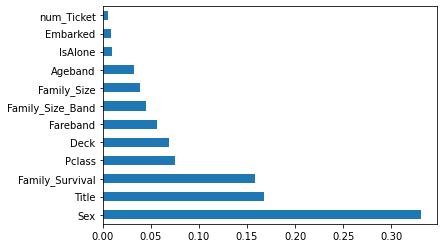

In [105]:
best_rf = best_clf_rf.best_estimator_.fit(X_train,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=train_df.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Check this out!!!
the model parameters were taken from another kernels. My best score was 0.81100. So, let's see how much we score in gs_rf, clf_rf_3, clf_rf_4. The main aim of these model parameters is to test how much better our model is comapred to some other kernels.   

In [106]:
clf_rf_3=RandomForestClassifier(criterion='gini', n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=1,
                                           n_jobs=-1,
                                           verbose=1)
best_clf_rf_3 = clf_rf_3.fit(X_train,y_train)
y_hat_rf_3 = best_clf_rf_3.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
rf_submission_3 = {'PassengerId': testing.PassengerId, 'Survived': y_hat_rf_3}
submission_rf_3 = pd.DataFrame(data=rf_submission_3)
submission_rf_3.to_csv('submission_rf_3.csv', index=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1100 out of 1100 | elapsed:    0.4s finished


# This got me a score of 0.80382

In [107]:
clf_rf_4=RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=1,
                                           n_jobs=-1,
                                           verbose=1)
best_clf_rf_4 = clf_rf_4.fit(X_train,y_train)
y_hat_rf_4 = best_clf_rf_4.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
rf_submission_4 = {'PassengerId': testing.PassengerId, 'Survived': y_hat_rf_4}
submission_rf_4 = pd.DataFrame(data=rf_submission_4)
submission_rf_4.to_csv('submission_rf_4.csv', index=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.6s finished


# This got me a score of 0.80861

with gs_rf a function copied from another kernel

In [108]:
rf_param_grid_best = {"max_depth": [None],
              "max_features": [3],
              "min_samples_split": [4],
              "min_samples_leaf": [5],
              "bootstrap": [False],
              "n_estimators" :[200],
              "criterion": ["gini"]}

gs_rf = GridSearchCV(rf, param_grid = rf_param_grid_best, cv=kfold, n_jobs= -1, verbose = 1)

gs_rf.fit(X_train, y_train)
rf_best = gs_rf.best_estimator_
print(f'RandomForest GridSearch best params: {gs_rf.best_params_}')
print(f'RandomForest GridSearch best score: {gs_rf.best_score_}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.3s finished


RandomForest GridSearch best params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 200}
RandomForest GridSearch best score: 0.8462636743886744


In [109]:
y_hat_gs_rf = gs_rf.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
rf_submission_gs = {'PassengerId': testing.PassengerId, 'Survived': y_hat_gs_rf}
submission_rf_gs = pd.DataFrame(data=rf_submission_gs)
submission_rf_gs.to_csv('submission_gs_rf.csv', index=False)

# This got me an accuracy of 0.80143

# 5. XGB Classifier 

In [110]:
'''xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [20, 50, 100, 250,300,400, 500,600,700,1000],
    'colsample_bytree': [0.2, 0.5, 0.7,0.75, 0.8,0.85, 0.9, 1],
    'max_depth': [2, 5, 10, 15, 20, 25, None],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2,2.5,3,4],
    'subsample': [0.5,0.55,0.6,0.65,0.7, 0.8, 0.9],
    'learning_rate':[.01,0.05,0.1,0.2,0.3,0.5,0.6,0.7,0.9],
    'gamma':[0,.01,.1,.5,1,10,100],
    'min_child_weight':[0,.01,0.05,0.1,1,10,100],
    'sampling_method': ['uniform', 'gradient_based']
}

clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 2000, 
cv = kfold, verbose = True, n_jobs = -1)
best_clf_xgb_rnd = clf_xgb_rnd.fit(X_train,y_train)
clf_performance(best_clf_xgb_rnd,'XGB')'''

'''XGB
Best Score: 0.8575048262548263
Best Parameters: {'subsample': 0.7, 'sampling_method': 'uniform', 
'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 700, 'min_child_weight': 0, 'max_depth': 10,
'learning_rate': 0.01, 'gamma': 0.01, 'colsample_bytree': 0.75}'''

"XGB\nBest Score: 0.8575048262548263\nBest Parameters: {'subsample': 0.7, 'sampling_method': 'uniform', \n'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 700, 'min_child_weight': 0, 'max_depth': 10,\n'learning_rate': 0.01, 'gamma': 0.01, 'colsample_bytree': 0.75}"

In [111]:
'''xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [550,600,650],
    'colsample_bytree': [0.9,0.95,1],
    'max_depth': [12,15,20],
    'reg_alpha': [0.5,1],
    'reg_lambda': [0.5,1],
    'subsample': [0.85,0.9,0.95],
    'learning_rate':[0.85,0.9,0.95],
    'gamma':[8,10,12],
    'min_child_weight':[0],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = kfold, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train,y_train)
clf_performance(best_clf_xgb,'XGB')'''

"xgb = XGBClassifier(random_state = 1)\n\nparam_grid = {\n    'n_estimators': [550,600,650],\n    'colsample_bytree': [0.9,0.95,1],\n    'max_depth': [12,15,20],\n    'reg_alpha': [0.5,1],\n    'reg_lambda': [0.5,1],\n    'subsample': [0.85,0.9,0.95],\n    'learning_rate':[0.85,0.9,0.95],\n    'gamma':[8,10,12],\n    'min_child_weight':[0],\n    'sampling_method': ['uniform']\n}\n\nclf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = kfold, verbose = True, n_jobs = -1)\nbest_clf_xgb = clf_xgb.fit(X_train,y_train)\nclf_performance(best_clf_xgb,'XGB')"

In [112]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [700],
    'colsample_bytree': [0.75],
    'max_depth': [10],
    'reg_alpha': [0.5],
    'reg_lambda': [2],
    'subsample': [0.7],
    'learning_rate':[0.01],
    'gamma':[.01],
    'min_child_weight':[0],
    'sampling_method': ['uniform']
}

clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 2000, cv = kfold, verbose = True, n_jobs = -1)
best_clf_xgb_rnd = clf_xgb_rnd.fit(X_train,y_train)
clf_performance(best_clf_xgb_rnd,'XGB')

Fitting 8 folds for each of 1 candidates, totalling 8 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 1 is smaller than n_iter=2000. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.4s finished


XGB
Best Score: 0.8575048262548263
Best Parameters: {'subsample': 0.7, 'sampling_method': 'uniform', 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 700, 'min_child_weight': 0, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.01, 'colsample_bytree': 0.75}


In [113]:
'''XGB
Best Score: 0.8575048262548263
Best Parameters: {'subsample': 0.7, 'sampling_method': 'uniform', 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 700, 'min_child_weight': 0, 'max_depth': 10,
'learning_rate': 0.01, 'gamma': 0.01, 'colsample_bytree': 0.75}'''

"XGB\nBest Score: 0.8575048262548263\nBest Parameters: {'subsample': 0.7, 'sampling_method': 'uniform', 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 700, 'min_child_weight': 0, 'max_depth': 10,\n'learning_rate': 0.01, 'gamma': 0.01, 'colsample_bytree': 0.75}"

In [114]:
y_hat_xgb_rnd = best_clf_xgb_rnd.best_estimator_.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
xgb_submission_rnd = {'PassengerId': testing.PassengerId, 'Survived': y_hat_xgb_rnd}
submission_xgb = pd.DataFrame(data=xgb_submission_rnd)
submission_xgb.to_csv('submission_xgb_rnd.csv', index=False)

# This got me a score of 0.79425

Again, the following model parameters were taken from another kernels.

In [115]:
xgb_param_grid_best = {'learning_rate':[0.1], 
                  'reg_lambda':[0.3],
                  'gamma': [1],
                  'subsample': [0.8],
                  'max_depth': [2],
                  'n_estimators': [300]
              }

gs_xgb = GridSearchCV(xgb, param_grid = xgb_param_grid_best, cv=kfold, n_jobs= -1, verbose = 1)

gs_xgb.fit(X_train,y_train)

xgb_best = gs_xgb.best_estimator_
print(f'XGB GridSearch best params: {gs_xgb.best_params_}')
print(f'XGB GridSearch best score: {gs_xgb.best_score_}')

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


XGB GridSearch best params: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300, 'reg_lambda': 0.3, 'subsample': 0.8}
XGB GridSearch best score: 0.8518741956241956


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.5s finished


In [116]:
y_hat_gs_xgb = gs_xgb.predict(X_test).astype(int)
testing=pd.read_csv('../input/titanic/test.csv')
gs_xgb_submission = {'PassengerId': testing.PassengerId, 'Survived': y_hat_gs_xgb}
submission_gs_xgb = pd.DataFrame(data=gs_xgb_submission)
submission_gs_xgb.to_csv('submission_gs_xgb_new.csv', index=False)

# This got me a core of 0.79186

# Model Additional Ensemble Approaches

In [117]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf
best_xgb = best_clf_xgb_rnd.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc)], voting = 'soft') 
voting_clf_all = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc),
                                                ('lr', best_lr)], voting = 'soft') 
voting_clf_xgb = VotingClassifier(estimators = [('knn',best_knn),('rf',best_rf),('svc',best_svc), 
                                                ('xgb', best_xgb),('lr', best_lr)], voting = 'soft')

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train,y_train,cv=kfold))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train,y_train,cv=kfold).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train,y_train,cv=kfold))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train,y_train,cv=kfold).mean())

print('voting_clf_all :',cross_val_score(voting_clf_all,X_train,y_train,cv=kfold))
print('voting_clf_all mean :',cross_val_score(voting_clf_all,X_train,y_train,cv=kfold).mean())

print('voting_clf_xgb :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=kfold))
print('voting_clf_xgb mean :',cross_val_score(voting_clf_xgb,X_train,y_train,cv=kfold).mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


voting_clf_hard : [0.85714286 0.84821429 0.84821429 0.9009009  0.83783784 0.81081081
 0.81981982 0.87387387]
Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


voting_clf_hard mean : 0.849601833976834
Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


voting_clf_soft : [0.86607143 0.83928571 0.84821429 0.89189189 0.83783784 0.81081081
 0.81981982 0.87387387]
Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


voting_clf_soft mean : 0.8473596364221365
Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s finished


voting_clf_all : [0.85714286 0.84821429 0.84821429 0.9009009  0.83783784 0.8018018
 0.82882883 0.87387387]
Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


voting_clf_all mean : 0.849601833976834
Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


voting_clf_xgb : [0.85714286 0.82142857 0.84821429 0.9009009  0.83783784 0.8018018
 0.81081081 0.87387387]
Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.9s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


voting_clf_xgb mean : 0.8440013674388674


In [118]:
#in a soft voting classifier you can weight some models more than others. I used a grid search to explore different weightings
#no new results here
params = {'weights' : [[1,1,1],[1,2,1],[1,1,2],[2,1,1],[2,2,1],[1,2,2],[2,1,2]]}

vote_weight = GridSearchCV(voting_clf_soft, param_grid = params, cv = kfold, verbose = True, n_jobs = -1)
best_clf_weight = vote_weight.fit(X_train,y_train)
clf_performance(best_clf_weight,'VC Weights')
voting_clf_sub = best_clf_weight.best_estimator_.predict(X_test)

Fitting 8 folds for each of 7 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:   51.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


VC Weights
Best Score: 0.85072796010296
Best Parameters: {'weights': [1, 2, 1]}


In [119]:
#Make Predictions 
voting_clf_hard.fit(X_train, y_train)
voting_clf_soft.fit(X_train, y_train)
voting_clf_all.fit(X_train, y_train)
voting_clf_xgb.fit(X_train, y_train)

best_rf.fit(X_train, y_train)
y_hat_vc_hard = voting_clf_hard.predict(X_test).astype(int)
y_hat_rf = best_rf.predict(X_test).astype(int)
y_hat_vc_soft =  voting_clf_soft.predict(X_test).astype(int)
y_hat_vc_all = voting_clf_all.predict(X_test).astype(int)
y_hat_vc_xgb = voting_clf_xgb.predict(X_test).astype(int)

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s finished


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.8s finished


In [120]:
#convert output to dataframe 
final_data = {'PassengerId': testing.PassengerId, 'Survived': y_hat_rf}
submission = pd.DataFrame(data=final_data)

final_data_2 = {'PassengerId': testing.PassengerId, 'Survived': y_hat_vc_hard}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': testing.PassengerId, 'Survived': y_hat_vc_soft}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_4 = {'PassengerId': testing.PassengerId, 'Survived': y_hat_vc_all}
submission_4 = pd.DataFrame(data=final_data_4)

final_data_5 = {'PassengerId': testing.PassengerId, 'Survived': y_hat_vc_xgb}
submission_5 = pd.DataFrame(data=final_data_5)

final_data_comp = {'PassengerId': testing.PassengerId, 'Survived_vc_hard': y_hat_vc_hard, 'Survived_rf': y_hat_rf, 'Survived_vc_soft' : y_hat_vc_soft, 'Survived_vc_all' : y_hat_vc_all,  'Survived_vc_xgb' : y_hat_vc_xgb}
comparison = pd.DataFrame(data=final_data_comp)

In [121]:
#track differences between outputs 
comparison['difference_rf_vc_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_rf else 0, axis =1)
comparison['difference_soft_hard'] = comparison.apply(lambda x: 1 if x.Survived_vc_hard != x.Survived_vc_soft else 0, axis =1)
comparison['difference_hard_all'] = comparison.apply(lambda x: 1 if x.Survived_vc_all != x.Survived_vc_hard else 0, axis =1)

In [122]:
#prepare submission files 
submission.to_csv('submission_rf_aug.csv', index =False)
submission_2.to_csv('submission_vc_hard_aug.csv',index=False)
submission_3.to_csv('submission_vc_soft_aug.csv', index=False)
submission_4.to_csv('submission_vc_all_aug.csv', index=False)
submission_5.to_csv('submission_vc_xgb_aug.csv', index=False)

# submission_vc_xgb_aug.csv scored 0.80861
# submission_vc_all_aug.csv scored 0.81100
# submission_vc_soft_aug.csv scored 0.79904
# submission_vc_hard_aug.csv scored 0.80143
# submission_rf_aug.csv scored 0.80382

# The best score which I could come with was 0.81100.
# As always, if we drop some columns which are a bit noisier (like Deck), and then if we perform a better feature tuning, we could come with a better accuracy score(results). 

# Upvote if you found this kernel helpful!!!